In [11]:
# SimPEG functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model, download, mkvc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TensorMesh

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

In [12]:
import os

folder_path = '../data/'

csv_files = np.array([f for f in os.listdir(folder_path) if f.endswith('.csv')])
csv_files = np.sort(csv_files)[:-1]
print(csv_files)

['2301.csv' '2302.csv' '2303.csv' '2304.csv' '2305.csv' '2306.csv'
 '2307.csv' '2308.csv' '2309.csv' '2310.csv' '2311.csv' '2312.csv'
 '2313.csv' '2314.csv' '2315.csv' '2316.csv' '2317.csv' '2318.csv'
 '2319.csv' '2320.csv' '2321.csv' '2322.csv']


In [13]:
import pandas as pd

In [14]:
df_collar = pd.read_csv("../data/locations.csv")

In [15]:
from ipywidgets import interact, widgets

[5, 6, 7*, 9*]

In [59]:
kk = 21
ii = 3


def foo(kk):
    #colors = ['k', 'b']
    
    df = pd.read_csv(folder_path+csv_files[kk])
    df_group = df.groupby('f (Hz)')
    base_freqs  = list(df_group.groups.keys())
    
    base_freq = base_freqs[ii]
    print (f"{folder_path+csv_files[kk]}, base freq:{base_freq:.0f} Hz")
    df_tmp = df_group.get_group(base_freq)
    i_start_time = 0
    voltage = df_tmp['V (mV/Am2)'].values[i_start_time:]
    noise = df_tmp['N (mV/Am2)'].values[i_start_time:]
    times = df_tmp['Time (s)'].values[i_start_time:]
    plt.errorbar(times, voltage, yerr=noise, marker='.', linestyle='None', color='k')
    plt.errorbar(times, -voltage, yerr=noise, marker='.', linestyle='None', color='b')
    plt.xscale('log')
    plt.yscale('log')
    # plt.loglog(times, noise, '.')
    plt.ylim(1e-8, 1)
    plt.xlim(1e-5, 1e-2)
    plt.title(csv_files[kk])
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV/Am2)")

interact(foo, 
         kk=widgets.IntSlider(min=0, max=21, step=1)
        )

interactive(children=(IntSlider(value=0, description='kk', max=21), Output()), _dom_classes=('widget-interact'…

<function __main__.foo(kk)>

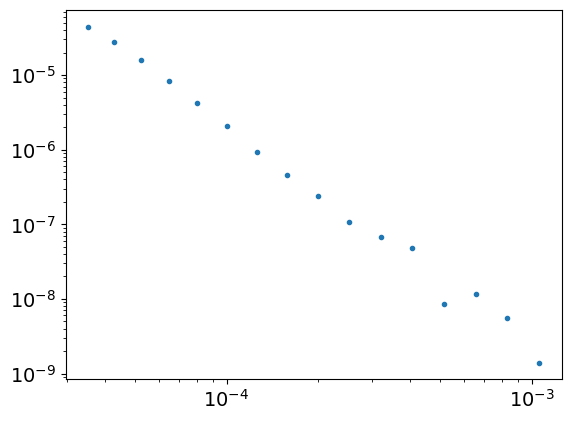

In [60]:
i_time_start = 0
i_time_end = 16
# Source properties
source_location = np.array([0.0, 0.0, 0.1]) # 0.1 m due to protem being on the ground
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current
source_radius = 56.4  # source loop radius (chosen from an area of 100x100)

# Receiver properties
receiver_location = np.array([0.0, 0.0, 0.1])
receiver_orientation = "z"  # "x", "y" or "z"
#times = np.logspace(-5, -2, 31)  # time channels (s)

# Define receiver list. In our case, we have only a single receiver for each source.
# When simulating the response for multiple component and/or field orientations,
# the list consists of multiple receiver objects.
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times[i_time_start:i_time_end], orientation=receiver_orientation
    )
)
rampoff_time=5.1e-6 #taken from email thread
freq = 75.0       
T = 1/freq         
I_peak = 1.0       

# calculate times
t1 = -T/2
t2 = t1 + rampoff_time
t3 = -rampoff_time
t4 = 0.0

time_input_current=np.array([t1, t2, t3, t4])
input_current=np.array([0.0, I_peak, I_peak, 0.0])

# Define the source waveform. Here we define a unit step-off. The definition of
# other waveform types is covered in a separate tutorial.

stepoff_waveform = tdem.sources.PiecewiseLinearWaveform(times=time_input_current, currents=input_current)

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=stepoff_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)
# 5% of the absolute value
uncertainties = (0.05 * np.abs(voltage*1e-3) * np.ones(np.shape(voltage*1e-3)))[i_time_start:i_time_end]
dobs = -voltage[i_time_start:i_time_end]*1e-3
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)
plt.loglog(times[i_time_start:i_time_end], -data_object.dobs, '.')
plt.loglog(times[i_time_start:i_time_end], +data_object.dobs, '.')

In [61]:
# estimated host conductivity (S/m)
estimated_conductivity = 0.001

# minimum diffusion distance
d_min = 1250 * np.sqrt(times.min() / estimated_conductivity)
print("MINIMUM DIFFUSION DISTANCE: {} m".format(d_min))

# maximum diffusion distance
d_max = 1250 * np.sqrt(times.max() / estimated_conductivity)
print("MAXIMUM DIFFUSION DISTANCE: {} m".format(d_max))

MINIMUM DIFFUSION DISTANCE: 234.68729194398233 m
MAXIMUM DIFFUSION DISTANCE: 2088.6598574205423 m


In [45]:
depth_min = 1.8  # top layer thickness
depth_max = 300.0  # depth to lowest layer
geometric_factor = 1.15  # rate of thickness increase

In [46]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print(n_layers)


25


In [47]:
log_conductivity_map = maps.ExpMap(nP=n_layers)

In [48]:
simulation_L2 = tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, sigmaMap=log_conductivity_map
)

In [49]:
#n_layers_model = len(layer_thicknesses_model) + 1

In [50]:
source_area = 10000

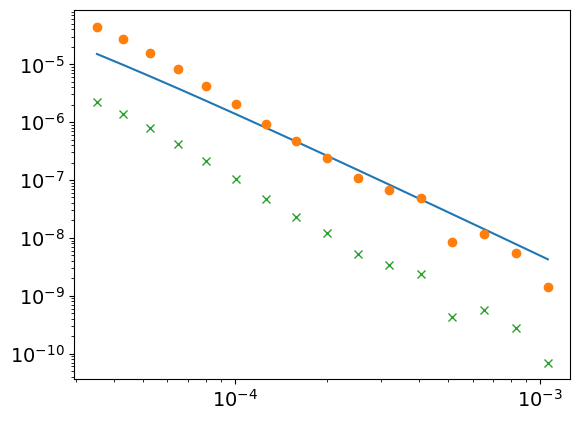

In [51]:
m0 = np.log(1./100 * np.ones(n_layers))
reference_conductivity=m0.copy()
dpred = simulation_L2.dpred(m0)
plt.loglog(times[i_time_start:i_time_end], -dpred)
plt.loglog(times[i_time_start:i_time_end], -dobs, 'o')
plt.loglog(times[i_time_start:i_time_end], uncertainties, 'x')
#print(n_layers)
#print(n_layers_model)

In [52]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

In [53]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 25 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     25       -376.31         -0.00      1.80     44.80    1.15




In [54]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    reference_model_in_smooth=False,
    alpha_s=1e-10,
    alpha_x=1,
)
opt_L2 = optimization.InexactGaussNewton(
    maxIter=15, maxIterLS=10, maxIterCG=50, tolCG=1e-3
)
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=1.0)
save_dict = directives.SaveOutputDictEveryIteration()
directives_list_L2 = [starting_beta, beta_schedule, target_misfit, save_dict]
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(m0)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


/opt/anaconda3/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


   0  1.13e+03  4.19e+03  1.84e-31  4.19e+03    3.70e+03      0              
   1  5.67e+02  2.98e+03  5.36e-03  2.98e+03    2.89e+03      2              
   2  2.83e+02  1.88e+03  2.48e-02  1.89e+03    3.09e+03      1   Skip BFGS  
   3  1.42e+02  6.42e+02  4.25e-02  6.48e+02    1.93e+03      0   Skip BFGS  
   4  7.08e+01  3.72e+02  4.28e-02  3.75e+02    2.28e+02      0   Skip BFGS  
   5  3.54e+01  3.67e+02  4.41e-02  3.68e+02    4.27e+00      0   Skip BFGS  
   6  1.77e+01  3.67e+02  4.50e-02  3.68e+02    1.37e+00      0   Skip BFGS  
   7  8.85e+00  3.67e+02  4.56e-02  3.67e+02    4.66e+00      1   Skip BFGS  
   8  4.43e+00  3.67e+02  4.66e-02  3.67e+02    9.49e+00      2              
   9  2.21e+00  3.67e+02  4.80e-02  3.67e+02    1.56e+01      3   Skip BFGS  
  10  1.11e+00  3.67e+02  4.88e-02  3.67e+02    1.70e+01      5   Skip BFGS  
  11  5.53e-01  3.67e+02  4.98e-02  3.67e+02    1.86e+01      6   Skip BFGS  
  12  2.77e-01  3.67e+02  5.08e-02  3.67e+02    2.00e+01      7 

In [55]:
inv_prob_L2.phi_d

366.7164431157571

In [56]:
survey.nD

16

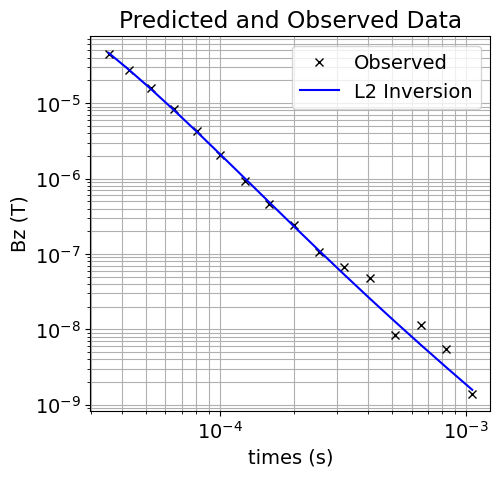

In [57]:
iterations = list(save_dict.outDict.keys())
iteration = len(iterations)
m_rec = save_dict.outDict[iteration]['m']
sigma_rec = log_conductivity_map * m_rec
dpred_rec = save_dict.outDict[iteration]['dpred']
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(times[i_time_start:i_time_end], np.abs(dobs), "kx")
ax1.loglog(times[i_time_start:i_time_end], np.abs(dpred_rec), "b-")
ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("Bz (T)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(["Observed", "L2 Inversion"], loc="upper right")
plt.show()

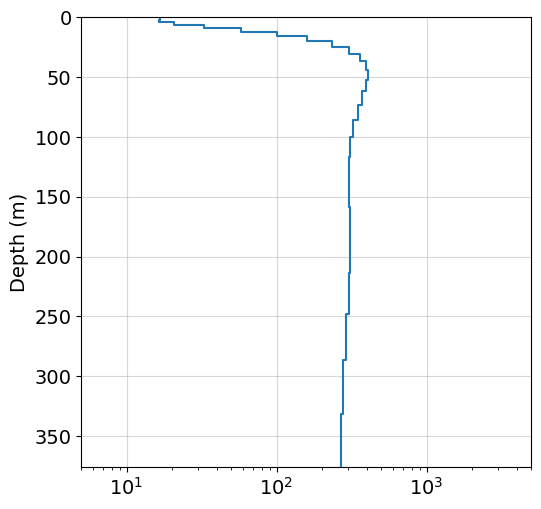

In [58]:
ax = plot_1d_layer_model(layer_thicknesses, 1./sigma_rec)
ax.set_xlim(5, 5e3)
ax.grid(True, alpha=0.5)